In [44]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer

In [46]:
test_component = pd.read_csv("test_components_contexts.csv")
train_component = pd.read_csv("train_components_contexts.csv")
validation_component = pd.read_csv("validation_components_contexts.csv")

test_component.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


In [47]:
# merge data
all_data = pd.concat([test_component, train_component, validation_component])

all_data.head()

,Year,Date,SectionID,ID,SpeechID,Label,Text,Start,End,SentenceID_begin,SentenceID_end,Current_Sentence,Previous_Sentence,Next_Sentence,Speaker,context1,context2
0,1960,21Oct,6,T289,2,Premise,the conditions I laid out in one of our previo...,429,496,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
1,1960,21Oct,6,T290,2,Premise,it's rather difficult to be much more specific...,502,558,0,0,NIXON: Well the conditions I laid out in one o...,NIXON: Well the conditions I laid out in one o...,"Uh - First of all, we have to have adequate pr...",NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
2,1960,21Oct,6,T291,2,Claim,we have to have adequate preparation for a sum...,579,639,1,1,"Uh - First of all, we have to have adequate pr...",NIXON: Well the conditions I laid out in one o...,This means at the secretary of state level and...,NIXON,Well the conditions I laid out in one of our ...,Well the conditions I laid out in one of our ...
3,1960,21Oct,6,T292,2,Premise,This means at the secretary of state level and...,641,714,2,2,This means at the secretary of state level and...,"Uh - First of all, we have to have adequate pr...",By adequate preparation I mean that at that le...,NIXON,"Uh - First of all, we have to have adequate pr...",Well the conditions I laid out in one of our ...
4,1960,21Oct,6,T293,2,Premise,By adequate preparation I mean that at that le...,716,863,3,3,By adequate preparation I mean that at that le...,This means at the secretary of state level and...,Now this agenda should delineate those issues ...,NIXON,This means at the secretary of state level and...,Well the conditions I laid out in one of our ...


In [48]:
# remove all the null context
print(len(all_data))
all_data = all_data[all_data['context1'].notnull()]
print(len(all_data))
# reduce size of the dataset to reduce the time to process
all_data = all_data.sample(n=int(len(all_data)/2)).sort_index()
print(len(all_data))


32988
32748
16374


In [49]:
#get unique values of label (our class for the classification)
classes = all_data['Label'].unique()

In [50]:
# convert label to class
all_data.Label = pd.Categorical(all_data.Label)
all_data['label_code'] = all_data.Label.cat.codes


In [51]:
# for the experience we only keep column context1 and label code
all_data = all_data[['Text', 'label_code']]

In [52]:

# split into train, test and validation samples (60% , 20% and 20%)
train, validation, test = np.split(all_data.sample(frac=0.4, random_state=42), [int(.2*len(all_data)), int(.3*len(all_data))])

print(len(train))
print(len(validation))
print(len(test))

3274
1638
1638


### Source
https://www.intodeeplearning.com/bert-multiclass-text-classification/

In [53]:
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [54]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks


In [55]:
train_input_ids, train_att_masks = encode(train['Text'].values.tolist())
valid_input_ids, valid_att_masks = encode(validation['Text'].values.tolist())
test_input_ids, test_att_masks = encode(test['Text'].values.tolist())


In [56]:
import torch
train_y = torch.LongTensor(train['label_code'].values.tolist())
valid_y = torch.LongTensor(validation['label_code'].values.tolist())
test_y = torch.LongTensor(test['label_code'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()


(torch.Size([3274]), torch.Size([1638]), torch.Size([1638]))

In [57]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)


In [58]:
from transformers import BertForSequenceClassification
N_labels = len(train.label_code.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [60]:
model = model.cuda()


In [61]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6
# LEARNING_RATE = 1e-3

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )


In [62]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(validation) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.8920590825197173 
103/103 val loss: 0.7515424542056705 
Epoch:  2


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.7023922774849869 
103/103 val loss: 0.6660417335704693 
Epoch:  3


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.6191568610144824 
103/103 val loss: 0.6147451351568537 
Epoch:  4


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5748846315756077 
103/103 val loss: 0.5964978733687725 
Epoch:  5


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5453275353443332 
103/103 val loss: 0.5924186093135945 
Epoch:  6


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.5162665553209258 
103/103 val loss: 0.5945757511750008 
Epoch:  7


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.48453637964841795 
103/103 val loss: 0.5988986269362921 
Epoch:  8


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.4718878950287656 
103/103 val loss: 0.6123918783896177 
Epoch:  9


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.44607080817222594 
103/103 val loss: 0.6120943618052214 
Epoch:  10


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.4330368722357401 
103/103 val loss: 0.6165551945422459 
Epoch:  11


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.4034406680886338 
103/103 val loss: 0.6286926877151415 
Epoch:  12


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.3941059404030079 
103/103 val loss: 0.6350575456920179 
Epoch:  13


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.36657513012973275 
103/103 val loss: 0.6506576296484586 
Epoch:  14


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.3572314614929804 
103/103 val loss: 0.6573117169940356 
Epoch:  15


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.33521818376895857 
103/103 val loss: 0.6723432192235317 
Epoch:  16


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.31571837888985144 
103/103 val loss: 0.6852586001736446 
Epoch:  17


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.30614675806789865 
103/103 val loss: 0.6965881573054397 
Epoch:  18


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2984039701339675 
103/103 val loss: 0.7072894389478905 
Epoch:  19


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.27761341315217136 
103/103 val loss: 0.7206790238908194 
Epoch:  20


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2680378395428018 
103/103 val loss: 0.7325151352917106 
Epoch:  21


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2697228540007661 
103/103 val loss: 0.7439982538084382 
Epoch:  22


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2503943648280167 
103/103 val loss: 0.7524781830391838 
Epoch:  23


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.25198922593419143 
103/103 val loss: 0.7619449681448704 
Epoch:  24


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2368223441991864 
103/103 val loss: 0.7704793023831636 
Epoch:  25


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.22150084407227796 
103/103 val loss: 0.7788525420485191 
Epoch:  26


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.23342767890270164 
103/103 val loss: 0.7826492777727183 
Epoch:  27


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.21397770496039856 
103/103 val loss: 0.7879562059652458 
Epoch:  28


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.2093003857063084 
103/103 val loss: 0.7922073811003305 
Epoch:  29


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.21214189393127836 
103/103 val loss: 0.7944534843407788 
Epoch:  30


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

205/205 train loss: 0.21284687484546405 
103/103 val loss: 0.7954333556219212 


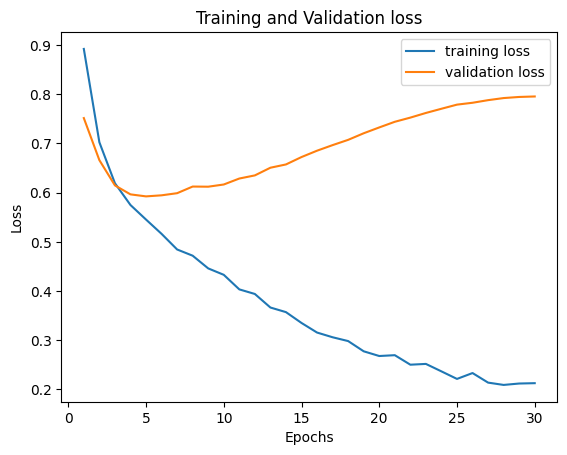

In [63]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


In [65]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, validation['label_code'].to_numpy(), target_names=classes))


classifiation report
              precision    recall  f1-score   support

     Premise       0.74      0.71      0.73       898
       Claim       0.67      0.69      0.68       740
    Question       0.00      0.00      0.00         0

    accuracy                           0.70      1638
   macro avg       0.47      0.47      0.47      1638
weighted avg       0.71      0.70      0.71      1638



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()


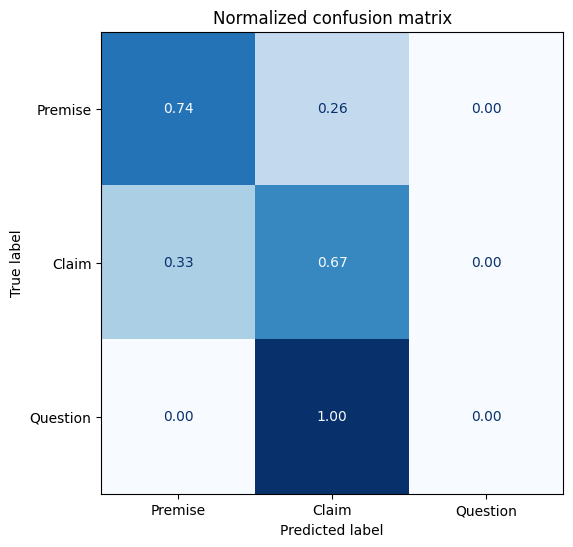

In [67]:
plot_confusion_matrix(valid_pred,validation['label_code'].to_numpy(),labels=classes)


In [68]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)


0it [00:00, ?it/s]

In [69]:
print('classifiation report')
print(classification_report(test_pred, test['label_code'].to_numpy(),target_names=classes))


classifiation report
              precision    recall  f1-score   support

     Premise       0.74      0.69      0.71       889
       Claim       0.66      0.72      0.69       749
    Question       0.00      0.00      0.00         0

    accuracy                           0.70      1638
   macro avg       0.47      0.47      0.47      1638
weighted avg       0.71      0.70      0.70      1638



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


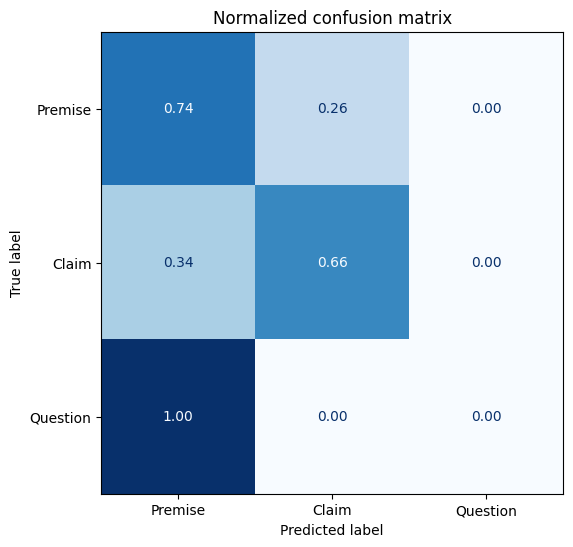

In [70]:
plot_confusion_matrix(test_pred,test['label_code'].to_numpy(),labels=classes)

In [71]:
test['pred'] = test_pred
test.reset_index(level=0)
print(test[test['label_code']!=test['pred']].shape)
test[test['label_code']!=test['pred']][['Text','label_code','pred']].head(10)

(488, 3)


,Text,label_code,pred
8758,we're going to say if you receive federal mone...,0,1
12396,They are now operating in 60 countries,0,1
7559,"That is the issue, not scaring people in America",1,0
16952,They do not pay us,1,0
3456,We don't need as much manpower on the Korean P...,1,0
3072,We're not doing as well amongst the people tha...,1,0
11736,I didn't hear a plan,0,1
5543,that our schools are working,0,1
10261,"as soon as they left, the voters would come ba...",0,1
9231,"She has no idea whether it's Russia, China, or...",0,1


In [74]:
print(len(all_data[all_data['label_code'] == 0]))
print(len(all_data[all_data['label_code'] == 1]))
print(len(all_data[all_data['label_code'] == 2]))

8542
7797
35
